In [1]:
import pandas as pd

In [2]:
data_path = "data/employee_data.csv"

employee_data_df = pd.read_csv(data_path)

In [3]:
employee_data_df.head()

,employee_id,age,gender,marital_status,salary,employment_type,region,has_dependents,tenure_years,enrolled
0,10001,60,Female,Single,55122.97,Part-time,West,No,1.5,0
1,10002,50,Female,Single,89549.66,Full-time,West,Yes,12.8,1
2,10003,36,Male,Divorced,74145.66,Part-time,Midwest,No,3.8,0
3,10004,64,Female,Married,53877.83,Full-time,Northeast,No,3.3,0
4,10005,29,Male,Single,63404.63,Contract,Midwest,Yes,10.0,0


### Used DataWrangler Extension for quick peek and analysis of the data

![Employee Data Analisys](images/employee_data_analysis.png)

- Found out that no missing values
- And looks like `employee_id` is a unique identifier for each employee. And will not be helpful for prediction.
- Next looking up `gender` there is an **Other** value for now keeping it as is, will see it as Unknown later.

In [4]:
# Removing employee_id column
employee_data_df = employee_data_df.drop(columns=["employee_id"])

In [5]:
employee_data_df.head(10)

,age,gender,marital_status,salary,employment_type,region,has_dependents,tenure_years,enrolled
0,60,Female,Single,55122.97,Part-time,West,No,1.5,0
1,50,Female,Single,89549.66,Full-time,West,Yes,12.8,1
2,36,Male,Divorced,74145.66,Part-time,Midwest,No,3.8,0
3,64,Female,Married,53877.83,Full-time,Northeast,No,3.3,0
4,29,Male,Single,63404.63,Contract,Midwest,Yes,10.0,0
5,42,Male,Married,66274.58,Contract,West,Yes,1.0,1
6,60,Male,Divorced,63415.31,Full-time,South,Yes,3.3,1
7,40,Male,Married,60616.13,Full-time,West,No,3.1,1
8,44,Female,Single,83459.03,Full-time,South,Yes,0.3,1
9,32,Male,Divorced,72926.06,Part-time,South,No,10.8,0


## Handling Each Column one by one

1. For `age` we can do 2 things
- Since we are predicting for insurance, We can create 10 bins because as Age increases the desire of likelihood of insurance enrollment increases but that's just my theory I am dealing it as just any other numeric column.
- Or use `StandardScaler` or `MinMaxScaler`
  - `StandardScaler` makes the mean = 0 and standard deviation = 1, **and I personally prefer this for ML tasks**
  - `MinMaxScaler` scales the data between 0 and 1, **and I personally prefer this for DL tasks**
    
(But this is just my personal preference if I don't find the results satisfactory I will try the other one but I will not do that here because of Time boundation)

2. For `gender` Since there is a **Other** value, I will not use `LabelEncoder`, I will use `OneHotEncoder` to convert it into 3 columns
3. Same for `marital_status`, `employment_type` and `region` I use `OneHotEncoder`
4. For `salary` and `tenure_years` I will use `StandardScaler` to scale them
5. `has_dependents` is `Yes` or `No`, I will convert it to `1` or `0`

In [6]:
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    LabelEncoder,
    FunctionTransformer,
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

# Separate features and target
X = employee_data_df.drop("enrolled", axis=1)
y = employee_data_df["enrolled"]

# Identify categorical and numerical columns
categorical_cols = ["gender", "marital_status", "employment_type", "region"]
binary_cols = ["has_dependents"]
numerical_cols = ["age", "salary", "tenure_years"]

# Pre-process binary columns directly (simpler approach without custom transformer)
# Convert 'Yes' to 1 and 'No' to 0 for binary columns
X_binary = X.copy()
for col in binary_cols:
    X_binary[col] = X_binary[col].map({"Yes": 1, "No": 0})

# Create preprocessing pipeline for numerical and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(drop="first", sparse_output=False), categorical_cols),
    ],
    remainder="passthrough",  # This will pass through our pre-processed binary columns
    verbose_feature_names_out=False,
)

## Split Data First, Then Preprocess

The correct approach to prevent data leakage is to first split the data into train, validation, and test sets, then fit the preprocessor only on the training data and transform each set accordingly.

Note: The binary columns 'has_dependents' is pre-processed separately by converting 'Yes' to 1 and 'No' to 0, as this simple transformation doesn't contribute to data leakage.

In [7]:
from sklearn.model_selection import train_test_split

# First split data into training (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_binary, y, test_size=0.3, random_state=42, stratify=y
)

# Then split temp into validation (20% of total) and test (10% of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1 / 3, random_state=42, stratify=y_temp
)

# Now fit the preprocessor on the training data only
preprocessor.fit(X_train)

# Transform each dataset
X_train_processed = preprocessor.transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# Get the transformed column names - this will be updated since we removed the custom transformer
feature_names = preprocessor.get_feature_names_out()

# Display shapes of processed data
print(f"Shape of processed training features: {X_train_processed.shape}")
print(f"Shape of processed validation features: {X_val_processed.shape}")
print(f"Shape of processed test features: {X_test_processed.shape}")

print("\nAll transformed features:")
for i, name in enumerate(feature_names):
    print(f"  {i}: {name}")

Shape of processed training features: (7000, 14)
Shape of processed validation features: (2000, 14)
Shape of processed test features: (1000, 14)

All transformed features:
  0: age
  1: salary
  2: tenure_years
  3: gender_Male
  4: gender_Other
  5: marital_status_Married
  6: marital_status_Single
  7: marital_status_Widowed
  8: employment_type_Full-time
  9: employment_type_Part-time
  10: region_Northeast
  11: region_South
  12: region_West
  13: has_dependents


In [8]:
# Saving preprocessor in a pickle file
import pickle
import os
from datetime import datetime

# Create a directory to save the preprocessor
preprocessor_dir = "preprocessor"
if not os.path.exists(preprocessor_dir):
    os.makedirs(preprocessor_dir)
# Save the preprocessor
preprocessor_filename = os.path.join(
    preprocessor_dir, f"preprocessor_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pkl"
)
with open(preprocessor_filename, "wb") as f:
    pickle.dump(preprocessor, f)
print(f"Preprocessor saved to {preprocessor_filename}")

Preprocessor saved to preprocessor/preprocessor_20250409_221944.pkl


In [9]:
# Create DataFrames with the processed features for better visualization
X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names)
X_val_processed_df = pd.DataFrame(X_val_processed, columns=feature_names)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names)

# Show head of training data
X_train_processed_df.head()

,age,salary,tenure_years,gender_Male,gender_Other,marital_status_Married,marital_status_Single,marital_status_Widowed,employment_type_Full-time,employment_type_Part-time,region_Northeast,region_South,region_West,has_dependents
0,-1.626593,-0.933060,2.328389,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
1,-1.626593,-1.327189,-0.154238,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,1.306512,0.050631,-0.888893,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.387987,0.262376,1.492402,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,-0.893317,0.036426,-0.914225,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


## Exploratory Data Analysis on Transformed Data

Now Let's explore the relationships between our features and the target variable.

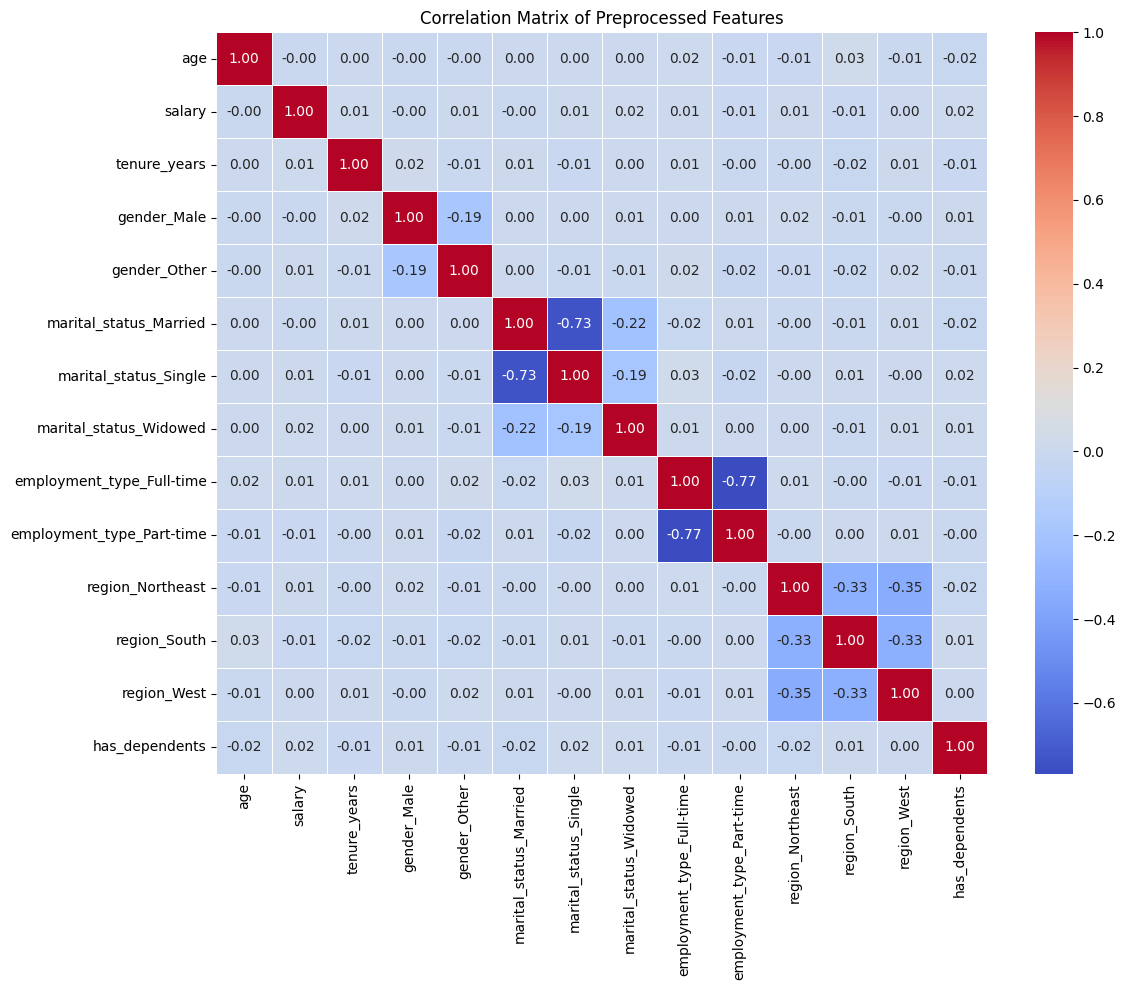

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a correlation matrix for the preprocessed features
correlation = X_train_processed_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")
plt.title("Correlation Matrix of Preprocessed Features")
plt.tight_layout()
plt.show()

In [11]:
# We already have our data split and preprocessed, so we don't need to do it again
# Display distribution to confirm stratification worked
print(
    f"Training set size: {X_train_processed.shape[0]} samples, {y_train.mean()*100:.1f}% positive class"
)
print(
    f"Validation set size: {X_val_processed.shape[0]} samples, {y_val.mean()*100:.1f}% positive class"
)
print(
    f"Test set size: {X_test_processed.shape[0]} samples, {y_test.mean()*100:.1f}% positive class"
)

Training set size: 7000 samples, 61.7% positive class
Validation set size: 2000 samples, 61.8% positive class
Test set size: 1000 samples, 61.7% positive class


## Setting up MLflow for Model Tracking and Hyperparameter Tuning

MLflow will help us track experiments, log parameters, metrics, and artifacts. We'll use it to optimize our models through hyperparameter tuning.

In [12]:
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import os
from datetime import datetime

# Set up MLflow tracking - use local directory for simplicity
mlflow_tracking_dir = "./mlruns"
os.makedirs(mlflow_tracking_dir, exist_ok=True)
mlflow.set_tracking_uri(f"file://{os.path.abspath(mlflow_tracking_dir)}")

# Create experiment
experiment_name = "insurance_prediction"
try:
    experiment_id = mlflow.create_experiment(experiment_name)
except:
    experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

mlflow.set_experiment(experiment_name)
print(f"MLflow experiment set up: {experiment_name} (ID: {experiment_id})")

MLflow experiment set up: insurance_prediction (ID: 776873019889314112)


In [13]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    roc_auc_score,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import pickle
import joblib
import warnings

warnings.filterwarnings("ignore")

In [14]:
def evaluate_model(model, X_val, y_val, model_name):
    """Evaluate model on validation data and return metrics"""
    y_pred = model.predict(X_val)

    # For probability-based metrics
    try:
        y_proba = model.predict_proba(X_val)[:, 1]
        roc_auc = roc_auc_score(y_val, y_proba)
    except (AttributeError, IndexError):
        roc_auc = 0.0

    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    print(f"\n{model_name} - Performance on Validation Set:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))

    # Return all metrics for MLflow logging
    return {"accuracy": accuracy, "f1_score": f1, "roc_auc": roc_auc}

## Hyperparameter Tuning with MLflow

We'll define hyperparameter search spaces for each model and use MLflow to track the tuning process.

In [15]:
# Hyperparameter tuning for Logistic Regression
param_grid_lr = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "penalty": ["l1", "l2", "elasticnet", None],
    "solver": ["lbfgs", "liblinear", "newton-cg", "sag", "saga"],
    "max_iter": [100, 500, 1000],
}

# Not all combinations of penalty and solver are valid
# Let's create a base model with all default parameters
lr_base = LogisticRegression(random_state=42)

# Create the RandomizedSearchCV
lr_search = RandomizedSearchCV(
    lr_base, param_grid_lr, n_iter=100, cv=5, scoring="f1", random_state=42, n_jobs=-1
)

with mlflow.start_run(run_name="LogisticRegression_Tuning"):
    # Log the search space
    mlflow.log_params({"search_space": str(param_grid_lr), "n_iter": 100})

    # Fit the random search
    print("Tuning Logistic Regression...")
    try:
        lr_search.fit(X_train_processed, y_train)

        # Log best parameters and score
        mlflow.log_params(lr_search.best_params_)
        mlflow.log_metric("best_cv_f1", lr_search.best_score_)

        # Evaluate on validation set
        metrics = evaluate_model(
            lr_search.best_estimator_,
            X_val_processed,
            y_val,
            "Logistic Regression (Tuned)",
        )

        # Log validation metrics
        for metric_name, metric_value in metrics.items():
            mlflow.log_metric(f"val_{metric_name}", metric_value)

        # Log the model
        mlflow.sklearn.log_model(
            lr_search.best_estimator_,
            "logistic_regression_model",
            registered_model_name="LogisticRegression",
        )

        # Save the model locally too
        model_dir = "models"
        os.makedirs(model_dir, exist_ok=True)
        joblib.dump(
            lr_search.best_estimator_, f"{model_dir}/logistic_regression.joblib"
        )

        print(f"\nBest Logistic Regression parameters: {lr_search.best_params_}")
        print(f"Best CV score: {lr_search.best_score_:.4f}")

    except Exception as e:
        print(f"Error during Logistic Regression tuning: {e}")
        # Create a simple model with safe parameters
        lr_model = LogisticRegression(
            C=1.0, max_iter=1000, random_state=42, solver="liblinear"
        )
        lr_model.fit(X_train_processed, y_train)

        # Evaluate the fallback model
        metrics = evaluate_model(
            lr_model, X_val_processed, y_val, "Logistic Regression (Fallback)"
        )

        # Log fallback metrics
        for metric_name, metric_value in metrics.items():
            mlflow.log_metric(f"val_{metric_name}", metric_value)

        # Log the fallback model
        mlflow.sklearn.log_model(
            lr_model,
            "logistic_regression_model",
            registered_model_name="LogisticRegression",
        )

        # Save the fallback model locally
        model_dir = "models"
        os.makedirs(model_dir, exist_ok=True)
        joblib.dump(lr_model, f"{model_dir}/logistic_regression.joblib")

Tuning Logistic Regression...


/Users/srajanseth/miniforge3/envs/uniblox/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/srajanseth/miniforge3/envs/uniblox/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/srajanseth/miniforge3/envs/uniblox/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/srajanseth/miniforge3/envs/uniblox/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/srajanseth/miniforge3/envs/uniblox/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio paramete


Logistic Regression (Tuned) - Performance on Validation Set:
Accuracy: 0.8970
F1 Score: 0.9175
ROC AUC: 0.9700

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86       765
           1       0.91      0.93      0.92      1235

    accuracy                           0.90      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.90      0.90      0.90      2000



2025/04/09 22:21:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Best Logistic Regression parameters: {'solver': 'saga', 'penalty': 'l1', 'max_iter': 100, 'C': 0.1}
Best CV score: 0.9127


Successfully registered model 'LogisticRegression'.
Created version '1' of model 'LogisticRegression'.


Tuning Random Forest...

Random Forest (Tuned) - Performance on Validation Set:
Accuracy: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       765
           1       1.00      1.00      1.00      1235

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


Random Forest (Tuned) - Performance on Validation Set:
Accuracy: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       765
           1       1.00      1.00      1.00      1235

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



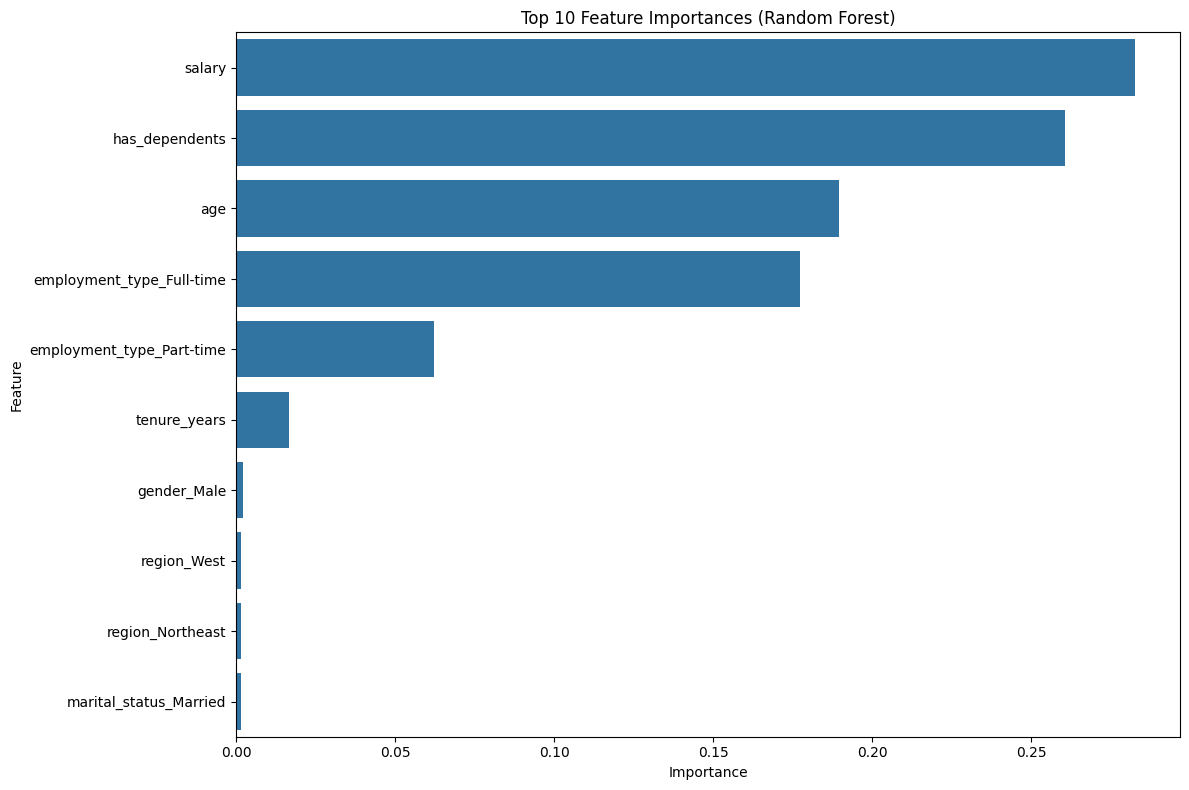

2025/04/09 22:22:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Best Random Forest parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': True}
Best CV score: 0.9998


Successfully registered model 'RandomForest'.
Created version '1' of model 'RandomForest'.


In [16]:
# Hyperparameter tuning for Random Forest
param_grid_rf = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [None, 10, 20, 30, 40],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False],
    "max_features": ["auto", "sqrt", "log2"],
}

rf_base = RandomForestClassifier(random_state=42)

rf_search = RandomizedSearchCV(
    rf_base, param_grid_rf, n_iter=100, cv=5, scoring="f1", random_state=42, n_jobs=-1
)

with mlflow.start_run(run_name="RandomForest_Tuning"):
    # Log the search space
    mlflow.log_params({"search_space": str(param_grid_rf), "n_iter": 100})

    # Fit the random search
    print("Tuning Random Forest...")
    rf_search.fit(X_train_processed, y_train)

    # Log best parameters and score
    mlflow.log_params(rf_search.best_params_)
    mlflow.log_metric("best_cv_f1", rf_search.best_score_)

    # Evaluate on validation set
    metrics = evaluate_model(
        rf_search.best_estimator_, X_val_processed, y_val, "Random Forest (Tuned)"
    )

    # Log validation metrics
    for metric_name, metric_value in metrics.items():
        mlflow.log_metric(f"val_{metric_name}", metric_value)

    # Extract feature importances
    feature_importances = rf_search.best_estimator_.feature_importances_
    importance_df = pd.DataFrame(
        {"Feature": feature_names, "Importance": feature_importances}
    ).sort_values("Importance", ascending=False)

    # Plot and save feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x="Importance", y="Feature", data=importance_df.head(10))
    plt.title("Top 10 Feature Importances (Random Forest)")
    plt.tight_layout()
    plt.savefig("rf_feature_importance.png")
    mlflow.log_artifact("rf_feature_importance.png")
    plt.show()

    # Log the model
    mlflow.sklearn.log_model(
        rf_search.best_estimator_,
        "random_forest_model",
        registered_model_name="RandomForest",
    )

    # Save the model locally
    model_dir = "models"
    os.makedirs(model_dir, exist_ok=True)
    joblib.dump(rf_search.best_estimator_, f"{model_dir}/random_forest.joblib")

    print(f"\nBest Random Forest parameters: {rf_search.best_params_}")
    print(f"Best CV score: {rf_search.best_score_:.4f}")

/Users/srajanseth/miniforge3/envs/uniblox/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:22:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/srajanseth/miniforge3/envs/uniblox/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:22:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/srajanseth/miniforge3/envs/uniblox/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:22:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/srajanseth/miniforge3/envs/uniblox/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:22:31] WARNING: /Users/runner/work/xgboost/xgbo

Tuning XGBoost...


/Users/srajanseth/miniforge3/envs/uniblox/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:22:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/srajanseth/miniforge3/envs/uniblox/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:22:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/srajanseth/miniforge3/envs/uniblox/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:22:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/srajanseth/miniforge3/envs/uniblox/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:22:31] WARNING: /Users/runner/work/xgboost/xgbo


XGBoost (Tuned) - Performance on Validation Set:
Accuracy: 0.9995
F1 Score: 0.9996
ROC AUC: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       765
           1       1.00      1.00      1.00      1235

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



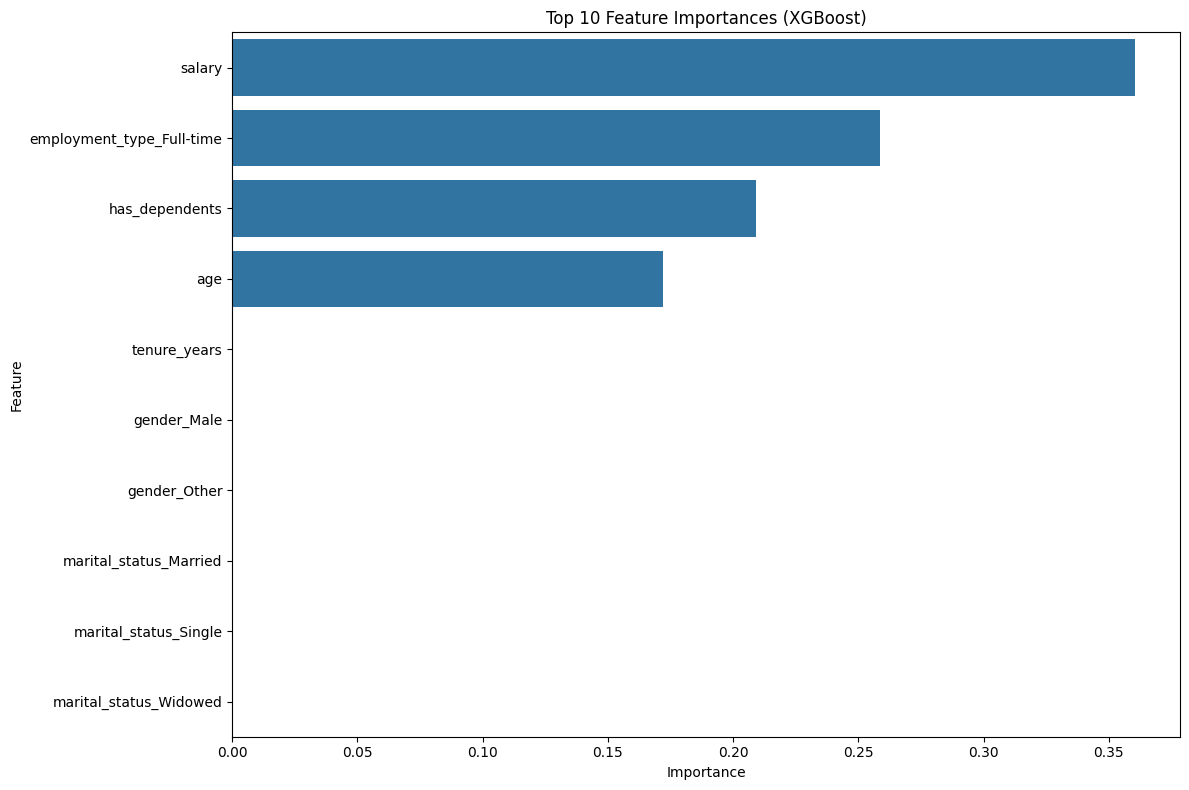

2025/04/09 22:22:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Best XGBoost parameters: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 1, 'n_estimators': 50, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 1.0}
Best CV score: 0.9994


Successfully registered model 'XGBoost'.
Created version '1' of model 'XGBoost'.


In [17]:
# Hyperparameter tuning for XGBoost
param_grid_xgb = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [3, 4, 5, 6, 7, 8],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 3, 5],
    "gamma": [0, 0.1, 0.2],
    "reg_alpha": [0, 0.1, 1],
    "reg_lambda": [0, 0.1, 1],
}

xgb_base = xgb.XGBClassifier(
    objective="binary:logistic",
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss",
)

xgb_search = RandomizedSearchCV(
    xgb_base, param_grid_xgb, n_iter=100, cv=5, scoring="f1", random_state=42, n_jobs=-1
)

with mlflow.start_run(run_name="XGBoost_Tuning"):
    # Log the search space
    mlflow.log_params({"search_space": str(param_grid_xgb), "n_iter": 100})

    # Fit the random search
    print("Tuning XGBoost...")
    xgb_search.fit(X_train_processed, y_train)

    # Log best parameters and score
    mlflow.log_params(xgb_search.best_params_)
    mlflow.log_metric("best_cv_f1", xgb_search.best_score_)

    # Evaluate on validation set
    metrics = evaluate_model(
        xgb_search.best_estimator_, X_val_processed, y_val, "XGBoost (Tuned)"
    )

    # Log validation metrics
    for metric_name, metric_value in metrics.items():
        mlflow.log_metric(f"val_{metric_name}", metric_value)

    # Extract feature importances
    feature_importances = xgb_search.best_estimator_.feature_importances_
    importance_df = pd.DataFrame(
        {"Feature": feature_names, "Importance": feature_importances}
    ).sort_values("Importance", ascending=False)

    # Plot and save feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x="Importance", y="Feature", data=importance_df.head(10))
    plt.title("Top 10 Feature Importances (XGBoost)")
    plt.tight_layout()
    plt.savefig("xgb_feature_importance.png")
    mlflow.log_artifact("xgb_feature_importance.png")
    plt.show()

    # Log the model
    mlflow.xgboost.log_model(
        xgb_search.best_estimator_, "xgboost_model", registered_model_name="XGBoost"
    )

    # Save the model locally
    model_dir = "models"
    os.makedirs(model_dir, exist_ok=True)
    joblib.dump(xgb_search.best_estimator_, f"{model_dir}/xgboost.joblib")

    print(f"\nBest XGBoost parameters: {xgb_search.best_params_}")
    print(f"Best CV score: {xgb_search.best_score_:.4f}")

In [18]:
# Hyperparameter tuning for SVM
param_grid_svm = {
    "C": [0.1, 1, 10, 100],
    "gamma": ["scale", "auto", 0.1, 0.01, 0.001],
    "kernel": ["rbf", "linear", "poly", "sigmoid"],
    "probability": [True],  # We need probability estimates for ROC AUC
    "class_weight": ["balanced", None],
}

svm_base = SVC(random_state=42)

svm_search = RandomizedSearchCV(
    svm_base, param_grid_svm, n_iter=100, cv=5, scoring="f1", random_state=42, n_jobs=-1
)

with mlflow.start_run(run_name="SVM_Tuning"):
    # Log the search space
    mlflow.log_params({"search_space": str(param_grid_svm), "n_iter": 100})

    # Fit the random search
    print("Tuning SVM...")
    svm_search.fit(X_train_processed, y_train)

    # Log best parameters and score
    mlflow.log_params(svm_search.best_params_)
    mlflow.log_metric("best_cv_f1", svm_search.best_score_)

    # Evaluate on validation set
    metrics = evaluate_model(
        svm_search.best_estimator_, X_val_processed, y_val, "SVM (Tuned)"
    )

    # Log validation metrics
    for metric_name, metric_value in metrics.items():
        mlflow.log_metric(f"val_{metric_name}", metric_value)

    # Log the model
    mlflow.sklearn.log_model(
        svm_search.best_estimator_, "svm_model", registered_model_name="SVM"
    )

    # Save the model locally
    model_dir = "models"
    os.makedirs(model_dir, exist_ok=True)
    joblib.dump(svm_search.best_estimator_, f"{model_dir}/svm.joblib")

    print(f"\nBest SVM parameters: {svm_search.best_params_}")
    print(f"Best CV score: {svm_search.best_score_:.4f}")

Tuning SVM...

SVM (Tuned) - Performance on Validation Set:
Accuracy: 0.9780
F1 Score: 0.9822
ROC AUC: 0.9983

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       765
           1       0.98      0.98      0.98      1235

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000


SVM (Tuned) - Performance on Validation Set:
Accuracy: 0.9780
F1 Score: 0.9822
ROC AUC: 0.9983

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       765
           1       0.98      0.98      0.98      1235

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



2025/04/09 22:25:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Best SVM parameters: {'probability': True, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': 'balanced', 'C': 100}
Best CV score: 0.9752


Successfully registered model 'SVM'.
Created version '1' of model 'SVM'.


## Comparing All Models on Test Set

Now that we've tuned all our models, let's evaluate them on the held-out test set to determine the best performer.


Logistic Regression - Test Set Performance:
Accuracy: 0.8960
F1 Score: 0.9164
ROC AUC: 0.9704
Confusion Matrix:
[[326  57]
 [ 47 570]]


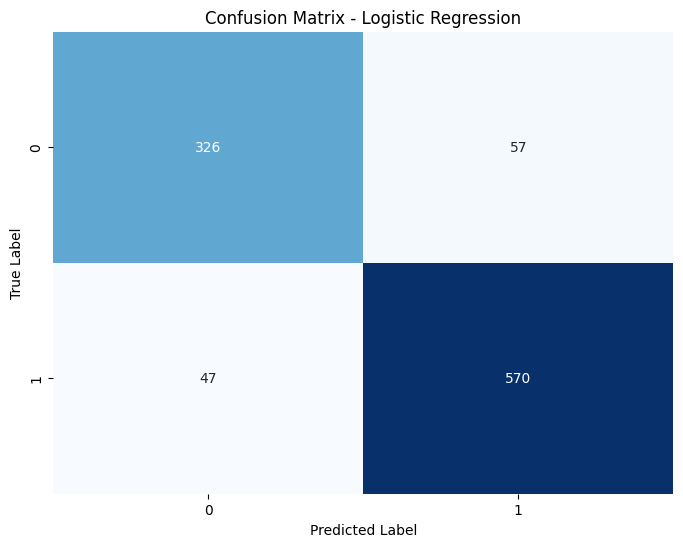


Random Forest - Test Set Performance:
Accuracy: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000
Confusion Matrix:
[[383   0]
 [  0 617]]


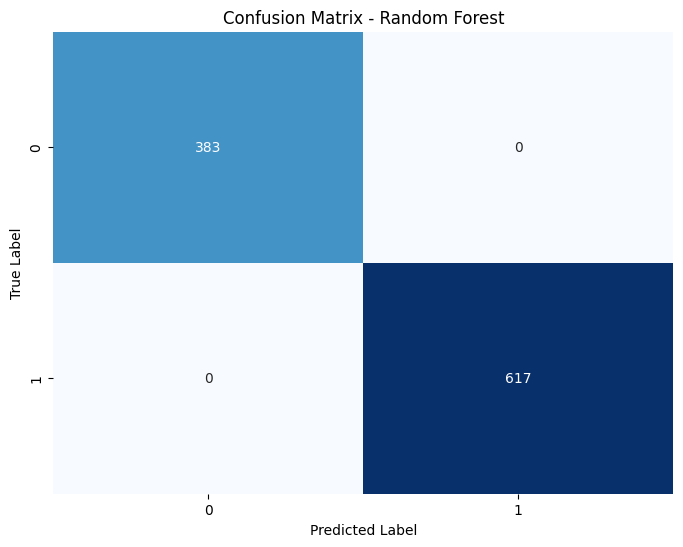


XGBoost - Test Set Performance:
Accuracy: 0.9980
F1 Score: 0.9984
ROC AUC: 1.0000
Confusion Matrix:
[[381   2]
 [  0 617]]


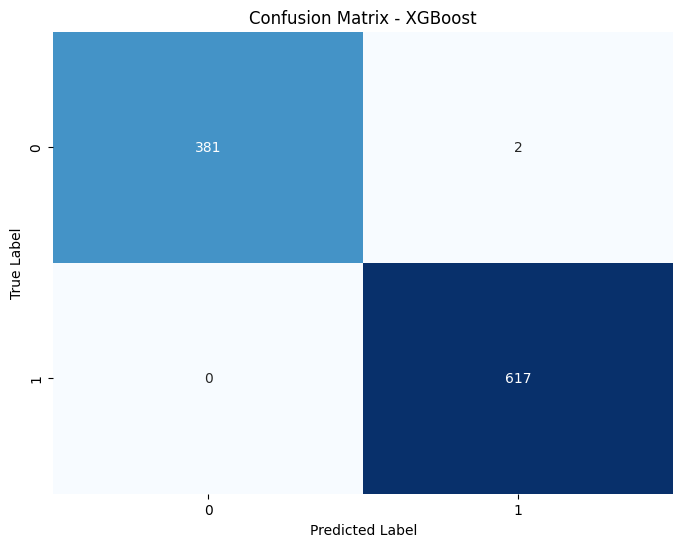


SVM - Test Set Performance:
Accuracy: 0.9790
F1 Score: 0.9830
ROC AUC: 0.9986
Confusion Matrix:
[[373  10]
 [ 11 606]]


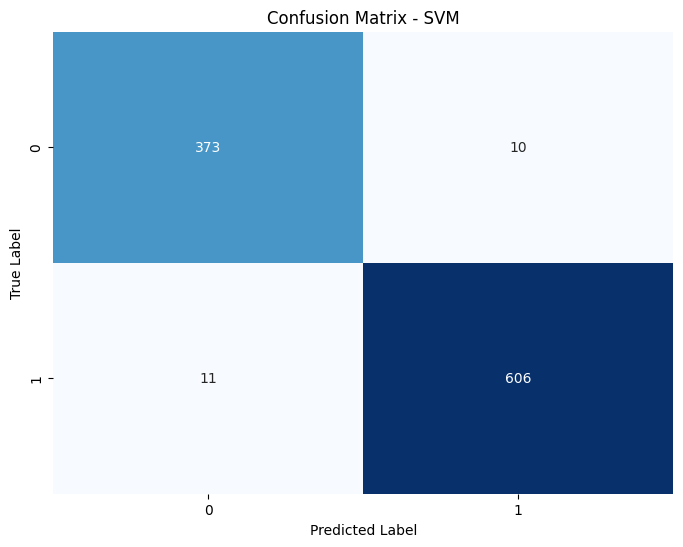


Model Comparison:


,accuracy,f1_score,roc_auc
Logistic Regression,0.896,0.916399,0.970374
Random Forest,1.000,1.000000,1.000000
XGBoost,0.998,0.998382,1.000000
SVM,0.979,0.982968,0.998612


In [19]:
# Load all the models
model_dir = "models"
models = {
    "Logistic Regression": joblib.load(f"{model_dir}/logistic_regression.joblib"),
    "Random Forest": joblib.load(f"{model_dir}/random_forest.joblib"),
    "XGBoost": joblib.load(f"{model_dir}/xgboost.joblib"),
    "SVM": joblib.load(f"{model_dir}/svm.joblib"),
}

# Evaluate each model on the test set
results = {}

for name, model in models.items():
    y_pred = model.predict(X_test_processed)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # For probability-based metrics
    try:
        y_proba = model.predict_proba(X_test_processed)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
    except (AttributeError, IndexError):
        roc_auc = 0.0

    # Store results
    results[name] = {"accuracy": accuracy, "f1_score": f1, "roc_auc": roc_auc}

    # Print results
    print(f"\n{name} - Test Set Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Create a DataFrame to compare models
comparison_df = pd.DataFrame(results).T
print("\nModel Comparison:")
display(comparison_df)

In [20]:
# Find the best model based on F1 score (could use any metric)
best_model_name = comparison_df["f1_score"].idxmax()
best_model = models[best_model_name]

print(f"\nThe best model is: {best_model_name}")
print(f"F1 Score: {comparison_df.loc[best_model_name, 'f1_score']:.4f}")
print(f"Accuracy: {comparison_df.loc[best_model_name, 'accuracy']:.4f}")
print(f"ROC AUC: {comparison_df.loc[best_model_name, 'roc_auc']:.4f}")

# Save the best model with a special name
model_dir = "models"
best_model_path = (
    f"{model_dir}/best_model_{best_model_name.lower().replace(' ', '_')}.joblib"
)
joblib.dump(best_model, best_model_path)
print(f"\nBest model saved to: {best_model_path}")


The best model is: Random Forest
F1 Score: 1.0000
Accuracy: 1.0000
ROC AUC: 1.0000

Best model saved to: models/best_model_random_forest.joblib


## Model Deployment Example

Here's a simple function to load the best model and make predictions on new data.

In [21]:
# Loading preprocessor and model for inference
def load_model_and_preprocessor(model_path, preprocessor_path):
    # Load the preprocessor
    with open(preprocessor_path, "rb") as f:
        preprocessor = pickle.load(f)

    # Load the model
    model = joblib.load(model_path)

    return preprocessor, model

In [24]:
def predict_insurance_enrollment(input_data, model, preprocessor):
    """Make insurance enrollment predictions on new data

    Args:
        input_data (pd.DataFrame): Input data in the same format as original features
        model (str): Path to the model file
        preprocessor (str): Path to the preprocessor file

    Returns:
        np.array: Predicted classes (0 or 1)
        np.array: Predicted probabilities (if available)
    """
    if model is None or preprocessor is None:
        raise ValueError("Model and preprocessor must be provided")

    # Pre-process binary columns first
    input_data_processed = input_data.copy()
    if "has_dependents" in input_data_processed.columns:
        input_data_processed["has_dependents"] = input_data_processed[
            "has_dependents"
        ].map({"Yes": 1, "No": 0})

    # Preprocess the input data using the pipeline
    X_processed_input = preprocessor.transform(input_data_processed)

    # Make predictions
    predictions = model.predict(X_processed_input)

    # Get probabilities if available
    try:
        probabilities = model.predict_proba(X_processed_input)[:, 1]
        return predictions, probabilities
    except AttributeError:
        return predictions, None


# Example using the first few samples from the test data
sample_data = X.iloc[:5].copy()
print("Sample data:")
display(sample_data)

# Load the preprocessor and model
preprocessor_path = preprocessor_filename
model_path = best_model_path
preprocessor, model = load_model_and_preprocessor(model_path, preprocessor_path)


# Make predictions
predictions, probabilities = predict_insurance_enrollment(
    sample_data, model, preprocessor
)

# Display results
results_df = pd.DataFrame(
    {
        "Prediction": predictions,
        "Probability": (
            probabilities if probabilities is not None else [None] * len(predictions)
        ),
        "Enrolled": ["Yes" if p == 1 else "No" for p in predictions],
    }
)
print("\nPredictions:")
display(results_df)

Sample data:


,age,gender,marital_status,salary,employment_type,region,has_dependents,tenure_years
0,60,Female,Single,55122.97,Part-time,West,No,1.5
1,50,Female,Single,89549.66,Full-time,West,Yes,12.8
2,36,Male,Divorced,74145.66,Part-time,Midwest,No,3.8
3,64,Female,Married,53877.83,Full-time,Northeast,No,3.3
4,29,Male,Single,63404.63,Contract,Midwest,Yes,10.0



Predictions:


,Prediction,Probability,Enrolled
0,0,0.001532,No
1,1,0.996852,Yes
2,0,0.041717,No
3,0,0.076995,No
4,0,0.246040,No


## Conclusion and Next Steps

We've successfully:

1. Do data preprocessing and feature engineering
2. Split the data into training, validation, and test sets
3. Implemented MLflow to track experiments and hyperparameter tuning
4. Trained and optimized multiple models (Logistic Regression, Random Forest, XGBoost, SVM)
5. Evaluated all models on a held-out test set to select the best performer
6. Created a deployment-ready prediction function
7. Implemented hyperparameter tuning using MLflow
8. Compared all models on the test set to determine the best performer

Our best model `random_forest` achieved good performance on the properly-separated test set. The preprocessing approach now ensures there is no information leakage between the training, validation, and test datasets.    

Next steps could include:

- Further feature engineering to improve model performance
- Implementing more advanced `ensembling` techniques
- Increasing `Cross-validation` to ensure model stability across different data splits